<a href="https://colab.research.google.com/github/hritik7080/Weather-Prediction-Time-Series-Forecasting/blob/master/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
Given dataset provides the weather data for city Delhi, India. We will try to analyze the weather and predict the temperature field - ***_tempm*** in the datset with ***Time Series Forecasting***.

# 1.a Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. b Read the dataset

In [11]:
df = pd.read_csv("testset.csv", index_col = 'datetime_utc', parse_dates = True)
df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


# 2. Exploratory Data Analysis

## a. Analysis of Weather

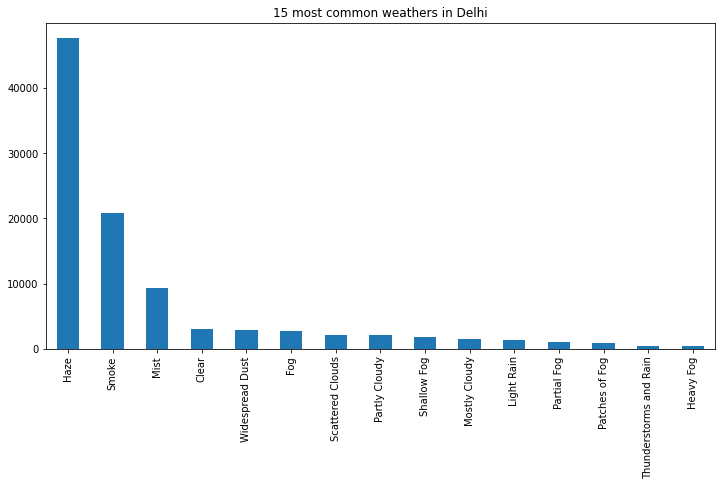

In [12]:
plt.figure(figsize=(12,6))
df[' _conds'].value_counts().head(15).plot(kind='bar')

plt.title('15 most common weathers in Delhi')
plt.show()

Deduction: It's mostly Haze/Smokey in Delhi.

## b. Temperature Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


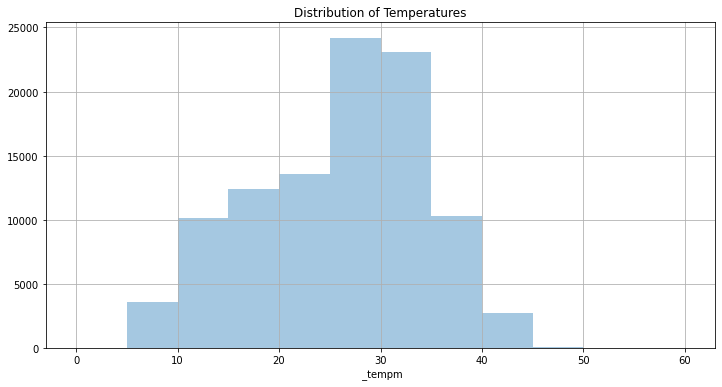

In [13]:
plt.figure(figsize=(12, 6))
sns.distplot(df[' _tempm'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()

Deduction: Temperature is mostly between 25 - 35 degree Celcius

# 3. Handle Missing Data

In [14]:
df.isna().sum()

 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [15]:
# Filter only Temperature column as we are interested in just that
data = pd.DataFrame(list(df[' _tempm']), index=df.index, columns=['temp'])
data = data.resample('H').mean()
data.head()

,temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 15:00:00,NaN


In [16]:
# replace the missing value by its previous non-null value
data.ffill()

,temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 15:00:00,24.0
...,...
2017-04-24 14:00:00,36.0
2017-04-24 15:00:00,32.0
2017-04-24 16:00:00,32.0


In [17]:
data.fillna(data['temp'].mean(), inplace=True)

In [18]:
data.temp.isna().sum()

0

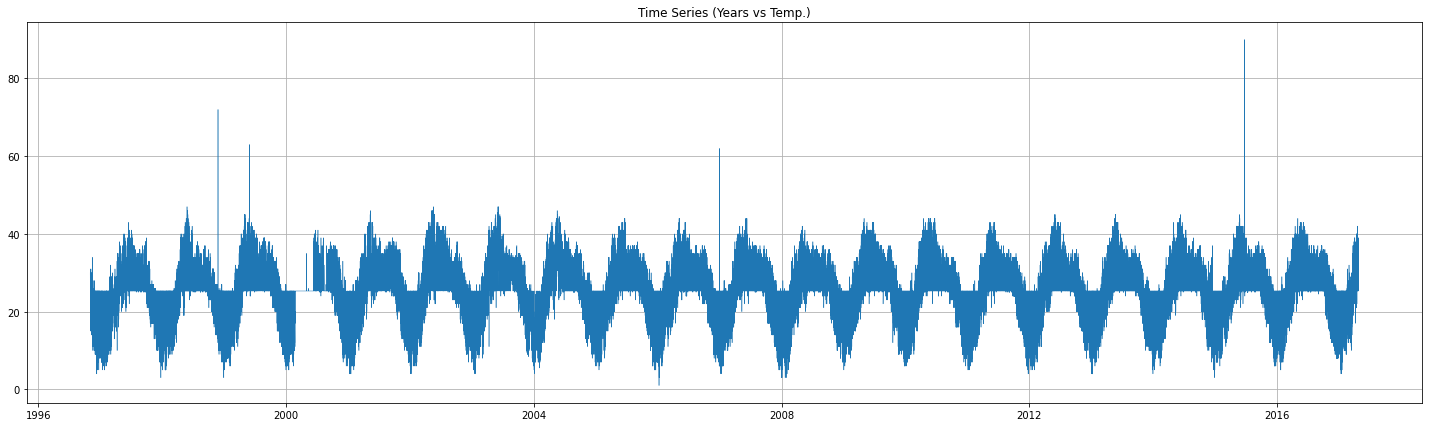

In [19]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

# 4. Scaling

In [20]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [21]:
data_scaled

array([[-0.34831461],
       [-0.39325843],
       [-0.48314607],
       ...,
       [-0.45352204],
       [-0.45352204],
       [-0.34831461]])

In [22]:
data_scaled.shape

(179504, 1)

In [23]:
timestep = 30
X= []
Y=[]
for i in range(len(data_scaled)- (timestep)):
    X.append(data_scaled[i:i+timestep])
    Y.append(data_scaled[i+timestep])

In [24]:
X=np.asanyarray(X)
Y=np.asanyarray(Y)

In [25]:
Y.shape

(179474, 1)

In [26]:
179474 - 150

179324

split the dataset into 150 points for test because that's how many days we will be forecasting in the future.

# 5. Train - Test Split

In [27]:
k = 179324
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:] 

In [28]:
X.shape

(179474, 30, 1)

##  Train the model

In [29]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential

In [30]:
from tensorflow.keras.layers import Bidirectional, Dropout

In [31]:
n_input = 30
n_features = 1
model = Sequential()

model.add(LSTM(150, activation = 'relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
history = model.fit(Xtrain, Ytrain, epochs=15, verbose=1)

Epoch 1/15
5604/5604 [==============================] - 274s 48ms/step - loss: 0.0092
Epoch 2/15
5604/5604 [==============================] - 266s 47ms/step - loss: 0.0040
Epoch 3/15
5604/5604 [==============================] - 258s 46ms/step - loss: 0.0031
Epoch 4/15
5604/5604 [==============================] - 262s 47ms/step - loss: 0.0029
Epoch 5/15
5604/5604 [==============================] - 273s 49ms/step - loss: 0.0028
Epoch 6/15
5604/5604 [==============================] - 278s 50ms/step - loss: 0.0027
Epoch 7/15
5604/5604 [==============================] - 280s 50ms/step - loss: 0.0026
Epoch 8/15
5604/5604 [==============================] - 283s 50ms/step - loss: 0.0025
Epoch 9/15
5604/5604 [==============================] - 282s 50ms/step - loss: 0.0024
Epoch 10/15
5604/5604 [==============================] - 277s 49ms/step - loss: 0.0024
Epoch 11/15
5604/5604 [==============================] - 275s 49ms/step - loss: 0.0024
Epoch 12/15
5604/5604 [=============================

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


## Plot the Loss against number of Epochs

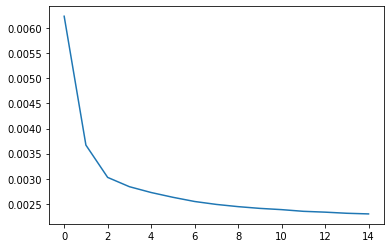

In [33]:
plt.plot(range(len(model.history.history['loss'])),
        model.history.history['loss'])

### Run the predict on test set

In [34]:
predict = model.predict(Xtest)

In [35]:
Ipredict = scalar.inverse_transform(predict)

In [36]:
Ytesting = scalar.inverse_transform(Ytest)

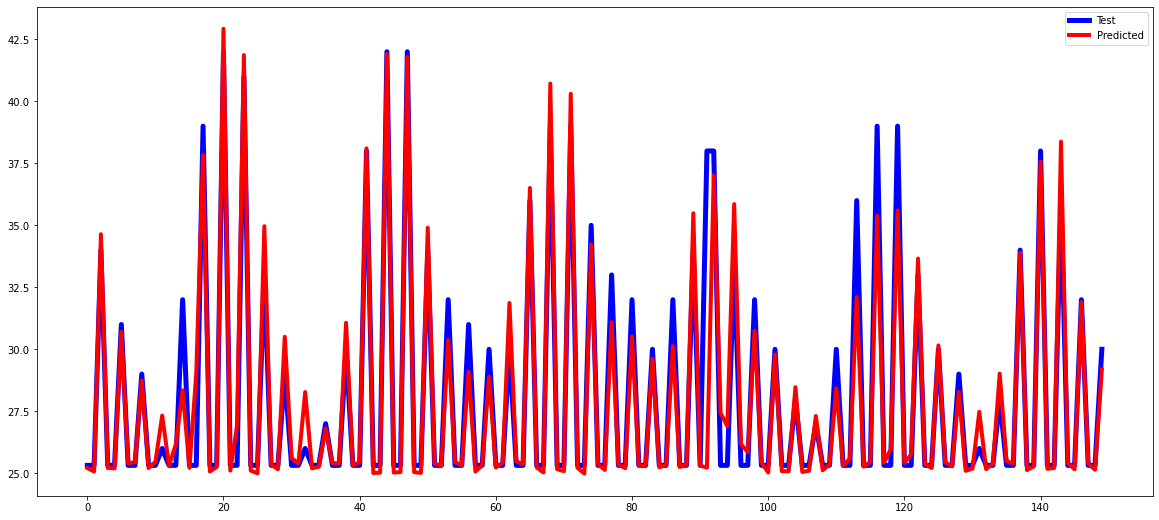

In [37]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(Ipredict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

# 5. Forecasting into Unknown Future

In [38]:
Xtest.shape

(150, 30, 1)

In [39]:
future_predictions = []
n_input = 30
n_features = 1
first_eval_batch = Xtest[-1]

current_batch = first_eval_batch.reshape((1,n_input, n_features))

for i in range(n_input):
    current_pred = model.predict(current_batch)[0]
    
    future_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :],[[current_pred]], axis = 1)

In [40]:
print(future_predictions)

[array([-0.3665895], dtype=float32), array([-0.4527356], dtype=float32), array([-0.45559368], dtype=float32), array([-0.39924598], dtype=float32), array([-0.4567122], dtype=float32), array([-0.4591234], dtype=float32), array([-0.423501], dtype=float32), array([-0.4598362], dtype=float32), array([-0.45773315], dtype=float32), array([-0.40156567], dtype=float32), array([-0.45528123], dtype=float32), array([-0.45403942], dtype=float32), array([-0.280457], dtype=float32), array([-0.45740178], dtype=float32), array([-0.45223206], dtype=float32), array([-0.20018132], dtype=float32), array([-0.4557491], dtype=float32), array([-0.45487335], dtype=float32), array([-0.22023302], dtype=float32), array([-0.4521072], dtype=float32), array([-0.4558723], dtype=float32), array([-0.31219122], dtype=float32), array([-0.4529402], dtype=float32), array([-0.45634937], dtype=float32), array([-0.37368047], dtype=float32), array([-0.4535572], dtype=float32), array([-0.45833257], dtype=float32), array([-0.4078

In [41]:
future_predictions = scalar.inverse_transform(future_predictions)

In [42]:
np.array(future_predictions)

array([[29.18676785],
       [25.35326567],
       [25.22608145],
       [27.73355401],
       [25.17630771],
       [25.06900857],
       [26.65420485],
       [25.03728844],
       [25.13087463],
       [27.63032764],
       [25.23998536],
       [25.2952456 ],
       [33.01966394],
       [25.14562069],
       [25.3756732 ],
       [36.59193125],
       [25.2191653 ],
       [25.25813578],
       [35.69963047],
       [25.38123   ],
       [25.21368277],
       [31.60749079],
       [25.34416129],
       [25.19245291],
       [28.87121898],
       [25.3167049 ],
       [25.10420071],
       [27.35244825],
       [25.0894825 ],
       [24.9470655 ]])

In [43]:
df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [44]:
future = pd.date_range('2017-04-24 19:00:00', periods = 30, freq = 'H')

In [45]:
dfd = pd.DataFrame(future_predictions, index = future, columns = ['Temp'])

In [46]:
dfd.head()

,Temp
2017-04-24 19:00:00,29.186768
2017-04-24 20:00:00,25.353266
2017-04-24 21:00:00,25.226081
2017-04-24 22:00:00,27.733554
2017-04-24 23:00:00,25.176308


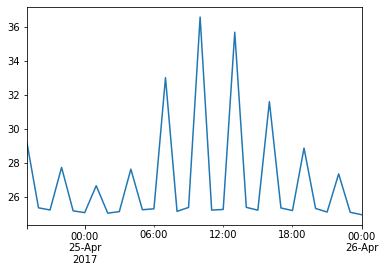

In [47]:
dfd['Temp'].plot()

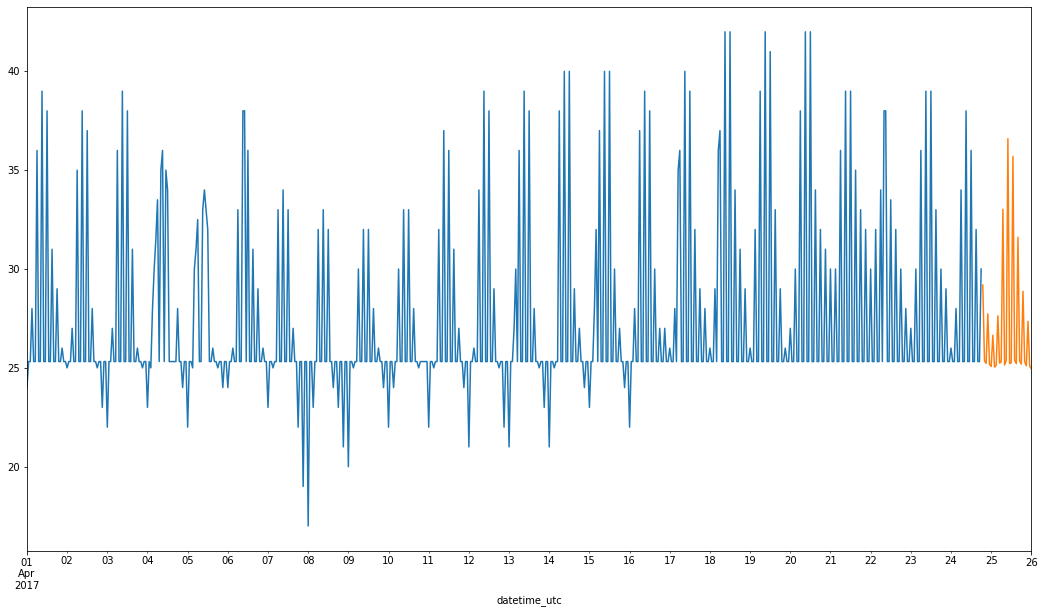

In [48]:
data['temp']['2017-04-01 00:00:00':].plot(figsize=(18,10))
dfd['Temp'].plot(figsize=(18,10))